# Writting the package documentation

We have made some good progress towards our first `v0.1.0` milestone. We have a fairly functional `Image` class in order to represent images loaded in memory. The next big step is to implement our addition function between two images.

## Experiment Test Driven Development

With this in mind, we are going to explore a new way of developing called TDD for Test Driven Development. The base idea of TDD is to start by implementing the unit tests before the functionality being tested. The rationale behind this approach is that, usually, the developer has a pretty good idea of the end result but a less clear idea of how this result will be achieved.

In our case, we know from our initial API reflexion that the expected result should be something like this:

```python
from calculator.image import Image
from calculator.add import add

img1 = Image.from_file("./image1.img")
img2 = Image.from_file("./image2.img")
img3 = add(img1, img2)
```

When you think about it, we almost have written our unit test already. Create a new file `tests/unittests/add_test.py` with the following content:

```python
import numpy as np
from numpy.testing import assert_array_equal

def test_image_addition(tmp_path):
    from calculator.add import add
    from calculator.image import Image
    
    (tmp_path / "image1.img").write_text("[[1, 2], [3, 4]]")
    (tmp_path / "image2.img").write_text("[[1, -1], [2, 0]]")

    img = add(
        Image.from_file(tmp_path / "image1.img"),
        Image.from_file(tmp_path / "image2.img"),
    )

    assert_array_equal(
        img._data,
        np.array([[2, 1], [5, 4]]),
    )
```

If you run the test suite, you'd get the following error:

```bash
$ pytest -vv tests
============================================== test session starts ==================================================
platform darwin -- Python 3.12.11, pytest-8.4.1, pluggy-1.6.0 -- /Users/nicolas.gensollen/miniforge3/envs/calculator/bin/python
cachedir: .pytest_cache
rootdir: /Users/nicolas.gensollen/GitRepos/calculator-lib
configfile: pyproject.toml
plugins: cov-6.2.1
collected 5 items

tests/unittests/add_test.py::test_image_addition FAILED                            [ 20%]
tests/unittests/image_test.py::test_image_instantiation PASSED                     [ 40%]
tests/unittests/image_test.py::test_image_data_set_correctly PASSED                [ 60%]
tests/unittests/image_test.py::test_bad_type_in_image_instantiation PASSED         [ 80%]
tests/unittests/image_test.py::test_image_from_file_constructor PASSED             [100%]

================================================ FAILURES =======================================================
___________________________________________ test_image_addition ________________________________________________

tmp_path = PosixPath('/private/var/folders/zk/9_vr9pfn69xcvgyvhkj59lpr000z9t/T/pytest-of-nicolas.gensollen/pytest-23/test_image_addition0')

    def test_image_addition(tmp_path):
>       from calculator.add import add
E       ImportError: cannot import name 'add' from 'calculator' (/Users/nicolas.gensollen/GitRepos/calculator-lib/src/calculator/__init__.py)

tests/unittests/add_test.py:2: ImportError
```

We get one failing test with an `ImportError`, which makes sense since we do not have an `add` module with an `add` function inside of it. Let's fix this error, and this error only: create a new file `src/calculator/add.py` with the following content:

```python
from .image import Image

def add(image1: Image, image2: Image) -> Image:
    pass
```

With this code, the test will be able to import an `add` function from the `add` module. Let's re-run our test suite. This time, we get a new error:

```python
tmp_path = PosixPath('/private/var/folders/zk/9_vr9pfn69xcvgyvhkj59lpr000z9t/T/pytest-of-nicolas.gensollen/pytest-28/test_image_addition0')

    def test_image_addition(tmp_path):
        from calculator._image import Image
        from calculator.add import add

        (tmp_path / "image1.img").write_text("[[1, 2], [3, 4]]")
        (tmp_path / "image2.img").write_text("[[1, -1], [2, 0]]")

        img = add(
            Image.from_file(tmp_path / "image1.img"),
            Image.from_file(tmp_path / "image2.img"),
        )

        assert_array_equal(
>           img._data,
            ^^^^^^^^^
            np.array([[2, 1], [5, 4]]),
        )
E       AttributeError: 'NoneType' object has no attribute '_data'

tests/unittests/add_test.py:16: AttributeError
```

This error is telling us that the result of the addition is None and that we cannot access the `_data` attribute of None since it doesn't exist. This, again, makes perfect sense that we have a None result since our add function doesn't return anything yet. Let's fix this issue:

```python
def add(image1: Image, image2: Image) -> Image:
    return Image.from_array([[1, 100], [-23, 0]])
```

If we re-run the test suite, we would get this new error:

```python
tmp_path = PosixPath('/private/var/folders/zk/9_vr9pfn69xcvgyvhkj59lpr000z9t/T/pytest-of-nicolas.gensollen/pytest-30/test_image_addition0')

    def test_image_addition(tmp_path):
        from calculator._image import Image
        from calculator.add import add

        (tmp_path / "image1.img").write_text("[[1, 2], [3, 4]]")
        (tmp_path / "image2.img").write_text("[[1, -1], [2, 0]]")

        img = add(
            Image.from_file(tmp_path / "image1.img"),
            Image.from_file(tmp_path / "image2.img"),
        )

>       assert_array_equal(
            img._data,
            np.array([[2, 1], [5, 4]]),
        )
E       AssertionError:
E       Arrays are not equal
E
E       Mismatched elements: 4 / 4 (100%)
E       Max absolute difference among violations: 99
E       Max relative difference among violations: 99.
E        ACTUAL: array([[  1, 100],
E              [-23,   0]])
E        DESIRED: array([[2, 1],
E              [5, 4]])

tests/unittests/add_test.py:16: AssertionError
```

Obviously, the test is failing because the returned image does not have the expected data. By now, you probably get the idea of TDD so let's finish our add function:

```pyhon
def add(image1: Image, image2: Image) -> Image:
    return Image.from_array(image1._data + image2._data)
```

If you re-run the tests, they should all pass now. First of all, remember this is a toy example and the package we are implementing doesn't really make sense (we are basically re-implementing the addition between 2D arrays...). It's the process that we follow which matters.

Second, you might think TDD in a waste of time since we could have immediately written this one line long function without going through all those steps. It's True for this simple example, but in more complex situations, TDD can be of great help and guide you, step by step, toward your objective. Moreover, it's also a way to guarantee that your code will be tested, which can be often overlooked once the implementation step is finished...

Third, you might have noticed that we doing something bad in our add function: we are accessing a private attribute of our Image class to perform the addition. It's easy to see because we applied the "_" rule. We need to fix this! One way would be to turn the attribute public, but that's not what we want. We initialy turned this attribute private because we don't want users to alter the image data. One possible solution is to make this attribute read-only but not mutable. In Python you can do this with the `@property` decorator. Let's modify our `Image` class like this:

```python
    (...)
    
    @property
    def data(self) -> np.ndarray:
        return self._data

    @classmethod
    def from_array(cls, data: list):
        (...)
```

We can then modify the code of the add function:

```python
def add(image1: Image, image2: Image) -> Image:
    return Image.from_array(image1.data + image2.data)
```

And verify that we didn't break anything by running the tests.

We are about to commit our code but suddenly it strikes us! We forgot what developers forget even more than unit tests... documentation.

Now that this poped in our mind, it's actually true that our prefered tools usually have this spot in our hearts because of their well thought, nice looking and welcoming documentation. We got to use these successful tools because it was easy and quick to find installation instructions, there was a super fast quick start tutorial to make the "Hello World" of the package run, a detailed user guide with plenty of examples, and a well crafted API documentation to be sure to know how to interact with the API.

If we want our package to be successful, actually even usable by other people, we need to write documentation. There's no way around it.

OK, so let's go for it !

As always in the Python world, there are several tools to do the job. The most famous tool for managing the documentation of a Python package is Sphinx, but there are pretty cool alternatives like mkdocs for example. Actually, in the Aramis team both Sphinx and mkdocs are used.

In this tutorial, we need to make a choice, so we'll go with Sphinx.

```bash
$ poetry add sphinx --group docs
Using version ^8.2.3 for sphinx

Updating dependencies
Resolving dependencies... (3.0s)

Package operations: 20 installs, 0 updates, 0 removals

  - Installing certifi (2025.6.15)
  - Installing charset-normalizer (3.4.2)
  - Installing idna (3.10)
  - Installing markupsafe (3.0.2)
  - Installing urllib3 (2.5.0)
  - Installing alabaster (1.0.0)
  - Installing babel (2.17.0)
  - Installing docutils (0.21.2)
  - Installing imagesize (1.4.1)
  - Installing jinja2 (3.1.6)
  - Installing requests (2.32.4)
  - Installing roman-numerals-py (3.1.0)
  - Installing snowballstemmer (3.0.1)
  - Installing sphinxcontrib-applehelp (2.0.0)
  - Installing sphinxcontrib-devhelp (2.0.0)
  - Installing sphinxcontrib-htmlhelp (2.1.0)
  - Installing sphinxcontrib-jsmath (1.0.1)
  - Installing sphinxcontrib-qthelp (2.0.0)
  - Installing sphinxcontrib-serializinghtml (2.0.0)
  - Installing sphinx (8.2.3)

Writing lock file
```

```toml
(...)
[tool.poetry.group.docs.dependencies]
sphinx = "^8.2.3"
(...)
```

```bash
$ mkdir docs
$ cd docs
$ sphinx-quickstart
$ tree
.
├── Makefile
├── _build
├── _static
├── _templates
├── conf.py
├── index.rst
└── make.bat

4 directories, 4 files
```


```bash
$ make html
```

- tools
- hosting platforms
- what makes a good doc (quickstart, install, user guide, example gallery, API reference, contributing guide...)
- configure and build our doc with Sphinx
- Use auto-API for the API reference

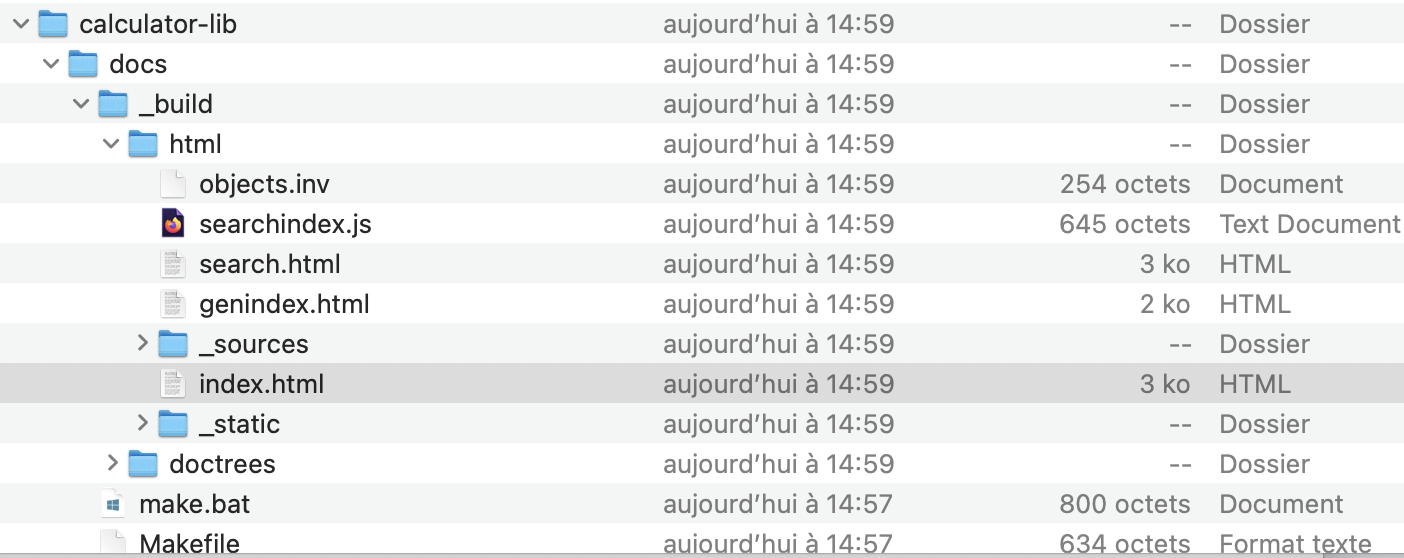

In [1]:
from IPython.display import Image

Image(filename="../images/index_doc.png")

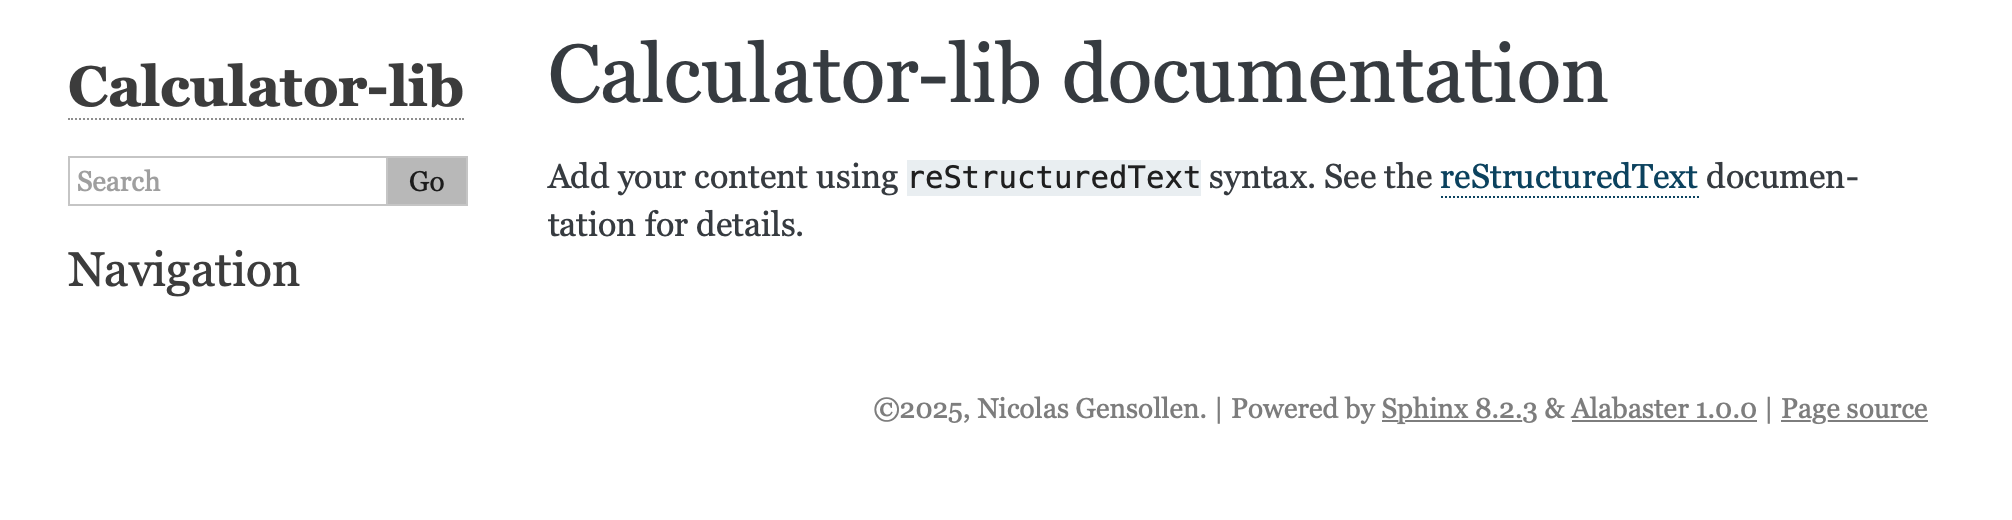

In [2]:
Image(filename="../images/documentation_1.png")

```rst
.. Calculator-lib documentation master file, created by
   sphinx-quickstart on Fri Jun 20 14:57:31 2025.
   You can adapt this file completely to your liking, but it should at least
   contain the root `toctree` directive.

Calculator-lib documentation
============================

This is the documentation of the image calculator library. It's gonna be great!


.. toctree::
   :maxdepth: 2
   :caption: Contents:
```

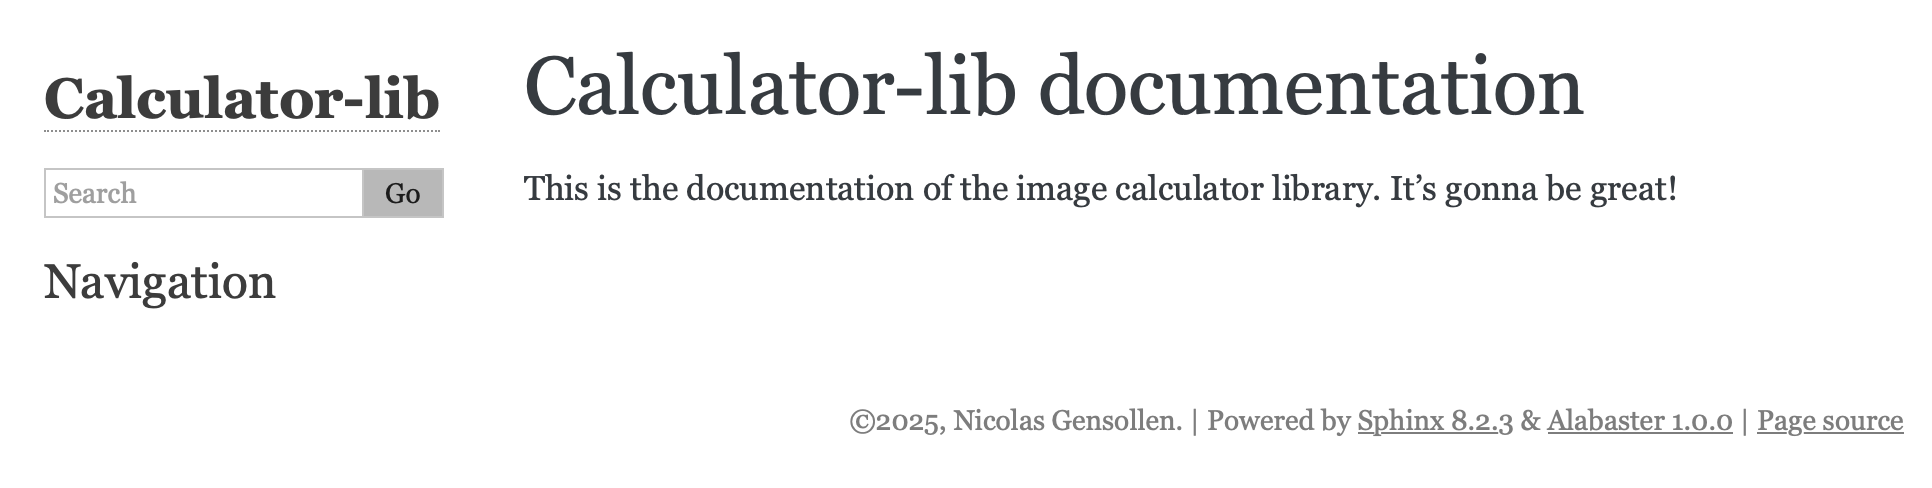

In [3]:
Image(filename="../images/documentation_2.png")